# Implementação de um contador automático de passageiros de ônibus
**Autores: Ronaldo Nunez e Vitor Lima**

**Disciplina IA898-A: Processamento digital de Imagens**

### Importando as dependências

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pims
from PIL import Image
from skimage import filters
import pandas as pd

#### Funções auxiliares

In [4]:
 def histogram(img, bins, range):
    h, be = np.histogram(img, bins=bins, range=range)
    w = range[-1]/bins
    bin_centers = be[1:]-(w/2)
    
    return bin_centers, h, w

In [5]:
def frame_analysis(frame_orig, frame_proc):
    tfig = plt.figure()

    tfig0 = plt.subplot2grid((4, 4), (0, 0), rowspan=2, colspan=2)
    tfig1 = plt.subplot2grid((4, 4), (0, 2), rowspan=2, colspan=2)
    tfig2 = plt.subplot2grid((4, 4), (2, 0), rowspan=2, colspan=4)
    
    tfig0.set_title('Frame original')
    tfig0.axis('off')
    tfig0.imshow(frame_orig, cmap='gray')

    tfig1.set_title('Frame subtraido')
    tfig1.axis('off')
    tfig1.imshow(frame_proc, cmap='gray')

    (bc, h , w) = histogram(frame_proc, 120, (0, 1.0))
    
    tfig2.bar(bc, h, width=w)

In [6]:
# Fonte: https://code.i-harness.com/en/q/c53fb2
def unique(array):
    uniq, index = np.unique(array, axis=0, return_index=True)
    return uniq[index.argsort()]

In [7]:
def to_gray(video):
    frames, width, hight, color = video.shape
    video_gray = np.zeros((frames, width, hight), dtype='uint32')
    
    for ii in range(len(video)):
        r, g, b = Image.fromarray(video[ii]).split()
        
        r = np.array(r, dtype='uint32')
        g = np.array(g, dtype='uint32')
        b = np.array(b, dtype='uint32')
        
        video_gray[ii] = (r + g + b) / 3
        
    return video_gray

### Abrindo os vídeos

In [44]:
v = pims.Video('../dataset/25_20160407_back/noisy/uncrowd/2016_04_07_09_09_57BackDepth.avi')

v_array = np.array(v)

Algumas informações sobre o vídeo aberto:

In [9]:
print(v.get_metadata())
print('\n', v_array.shape)

N_frames = v_array.shape[0]
width = v_array.shape[1]
height = v_array.shape[2]
channel_colors = v_array.shape[3]

{'plugin': 'ffmpeg', 'nframes': 384, 'ffmpeg_version': 'N-86111-ga441aa90e8-static http://johnvansickle.com/ffmpeg/ built with gcc 5.4.1 (Debian 5.4.1-8) 20170304', 'fps': 25.0, 'source_size': (320, 240), 'size': (320, 240), 'duration': 15.36}

 (384, 240, 320, 3)


Os campos da *tupla* anterior significam o seguinte:
(Frames, Altura, Largura, Cores)

### Pré-processamento

O pré-processamento consiste exclusivamente em deixar o vídeo em escala de cinza.

In [45]:
I = to_gray(v_array)
I.shape

(390, 240, 320)

### Determinando o modelo de fundo

In [11]:
# TODO: Implementar técnica de determinação automática de threshold

#### Background Modeling Independent of Time

In [12]:
def fgmask_BMIT(video, tao):
    B_BMIT = video[0] # background model
    D_BMIT = np.abs(video - B_BMIT) # background subtraction

    # foreground mask
    F_BMIT = D_BMIT.copy() 
    F_BMIT = F_BMIT / F_BMIT.max()
    F_BMIT[F_BMIT >= tao] = 1.0
    F_BMIT[F_BMIT < tao] = 0
    
    return F_BMIT

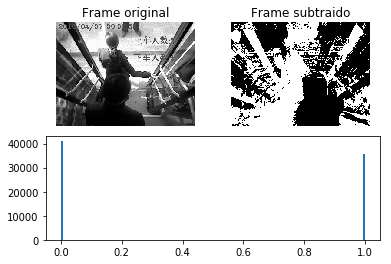

In [13]:
tao_BMIT = 0.98  # Threshold
F_BMIT = fgmask_BMIT(I, tao_BMIT)
frame_analysis(I[47], F_BMIT[47])

In [14]:
def fgmask_BMIT_otsu(video):
    B_BMIT = video[0] # background model
    D_BMIT = np.abs(video - B_BMIT) # background subtraction

    # foreground mask

    F_BMIT = D_BMIT.copy() 
    F_BMIT = F_BMIT / F_BMIT.max()
    tao = filters.threshold_otsu(F_BMIT)
    F_BMIT[F_BMIT >= tao] = 1.0
    F_BMIT[F_BMIT < tao] = 0
    
    return F_BMIT

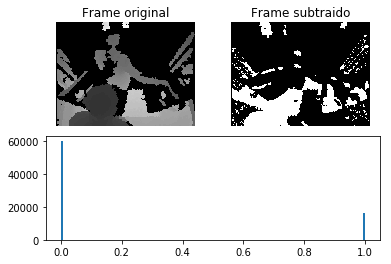

In [50]:
F_BMIT = fgmask_BMIT_otsu(I)
frame_analysis(I[47], F_BMIT[47])

####  The Long Term Average Background Modeling

In [16]:
def fgmask_LTABM(video, tao):
    # backgound model
    B_LTAMBM = np.zeros(video.shape)
    for k in range(1, len(video)):
        B_LTAMBM[k] = (1-1/k)*B_LTAMBM[k-1] + (1/k) *video[k]

    D_LTAMBM = np.abs(video - B_LTAMBM) # background subtraction

    # foreground mask
    F_LTAMBM = D_LTAMBM.copy() 
    F_LTAMBM = F_LTAMBM / F_LTAMBM.max()
    F_LTAMBM[F_LTAMBM >= tao_LTAMBM] = 1.0
    F_LTAMBM[F_LTAMBM < tao_LTAMBM] = 0
    
    return F_LTAMBM

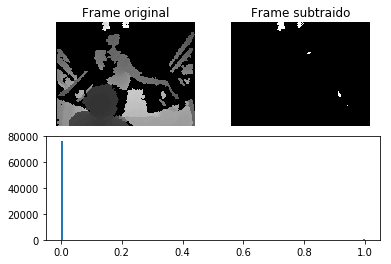

In [49]:
tao_LTAMBM = 0.2
F_LTAMBM = fgmask_LTABM(I, tao_LTAMBM)
frame_analysis(I[47], F_LTAMBM[47])

In [55]:
def fgmask_LTABM_otsu(video):
    # backgound model
    B_LTAMBM = np.zeros(video.shape)
    for k in range(1, len(video)):
        B_LTAMBM[k] = (1-1/k)*B_LTAMBM[k-1] + (1/k) *video[k]

    D_LTAMBM = np.abs(video - B_LTAMBM) # background subtraction
    # foreground mask
    F_LTAMBM = D_LTAMBM.copy() 
    F_LTAMBM = F_LTAMBM / F_LTAMBM.max()
    tao = filters.threshold_otsu(F_LTAMBM)
    F_LTAMBM[F_LTAMBM >= tao] = 1.0
    F_LTAMBM[F_LTAMBM < tao] = 0
    
    return F_LTAMBM

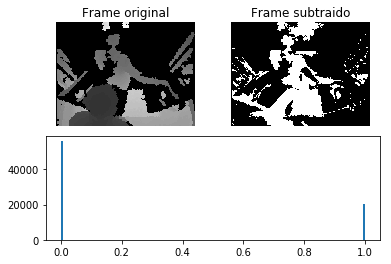

In [56]:
F_LTAMBM = fgmask_LTABM_otsu(I)
frame_analysis(I[47], F_LTAMBM[47])

#### Moving Average Backgound Modeling

In [20]:
def fgmodel_MABM(video, tao, past=10):
    # background modeling
    B_MABM = np.zeros(video.shape)
    for k in range((past-1), len(video)-1):
        B_MABM[k] = (1/past)*np.sum(video[(k-(past-1)):(k+1),:,:], axis=0)

    D_MABM = np.abs(video - B_MABM) # background subtraction

    # foreground mask
    F_MABM = D_MABM.copy() 
    F_MABM = F_MABM / F_MABM.max()
    F_MABM[F_MABM >= tao] = 1.0
    F_MABM[F_MABM < tao] = 0
    
    return F_MABM

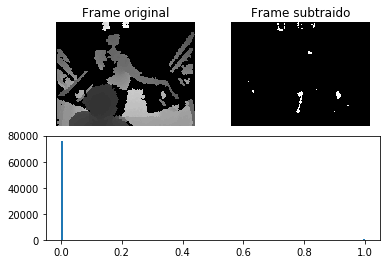

In [51]:
tao_MABM = 0.2
F_MABM = fgmodel_MABM(I, tao_MABM, 5)
frame_analysis(I[47], F_MABM[47])

In [22]:
def fgmodel_MABM_otsu(video, past=10):
    # background modeling
    B_MABM = np.zeros(video.shape)
    for k in range((past-1), len(video)-1):
        B_MABM[k] = (1/past)*np.sum(video[(k-(past-1)):(k+1),:,:], axis=0)

    D_MABM = np.abs(video - B_MABM) # background subtraction

    # foreground mask
    F_MABM = D_MABM.copy() 
    F_MABM = F_MABM / F_MABM.max()
    tao = filters.threshold_otsu(F_MABM)
    F_MABM[F_MABM >= tao] = 1.0
    F_MABM[F_MABM < tao] = 0
    
    return F_MABM

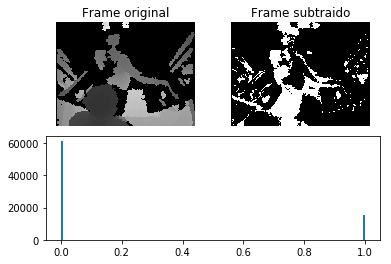

In [52]:
F_MABM = fgmodel_MABM_otsu(I, 20)
frame_analysis(I[47], F_MABM[47])

### Detecção

In [24]:
print(I.shape)

H = I.shape[1] # altura, em pixels, na direção do fluxo
W = I.shape[2] # largura, em pixels, perpendicular ao fluxo
print('H = {}, W = {}'.format(H, W))

K = 10
Theta = 0.2 # threshold: quanto da área ocupada

(384, 240, 320)
H = 240, W = 320


In [25]:
def active_strips(foregd_frame, Theta, H, W, K):
    delta = W / K

    C_area = delta * H/2
    A = np.array([], dtype='uint32')

    for C_i in np.hsplit(foregd_frame, K):
        for C_j in np.vsplit(C_i, 2):
            aux = 1 if ((C_j == 1).sum() >= C_area*Theta) else 0
            A = np.append(A, aux)

    A = np.vstack((A[0::2], A[1::2]))
    
    return A

In [26]:
def active_strips_changes(fgmodel_video, Theta, H, W, K):
    A_vid = np.zeros((fgmodel_video.shape[0], 2, K))

    i = 0
    for frame in fgmodel_video:
        A_vid[i] = active_strips(frame, Theta, H, W, K)
        i += 1

    return unique(A_vid)

In [27]:
A_teste = active_strips_changes(F_LTAMBM, 0.2, I.shape[1], I.shape[2], 10)

### Contagem automática

In [28]:
def people_counter(asc_video):
    people_brd = 0
    people_unbrd = 0

    for f in range(1, asc_video.shape[0]):
        for i in range(asc_video.shape[2]):
            if ((asc_video[f-1, 0, i] == 1) and 
                (asc_video[f-1, 1, i] == 0) and
                (asc_video[f, 1, i] == 1) ):
                people_brd += 1
            
            if ((asc_video[f-1, 0, i] == 0) and 
                (asc_video[f-1, 1, i] == 1) and
                (asc_video[f, 0, i] == 1) ):
                people_unbrd += 1


    return {'boarding': people_brd, 'unboarding': people_unbrd}

In [29]:
people_counter(A_teste)

{'boarding': 27, 'unboarding': 22}

### Implementando a técnica em uma única função

In [30]:
def apcs(video_path, seg_threshold, det_threshold, K=10, past=5, seg_tech='MABM', dirc='boarding'):
    v = pims.Video(video_path)
    v_array = np.array(v)
    
    I = to_gray(v_array)
    
    if (seg_tech == 'BMIT'):
        F_BMIT = fgmask_BMIT(I, seg_threshold)
        A_test = active_strips_changes(F_BMIT, det_threshold, I.shape[1], I.shape[2], K)
    elif(seg_tech == 'LTAMBM'):
        F_LTAMBM = fgmask_LTABM(I, seg_threshold)
        A_test = active_strips_changes(F_LTAMBM, det_threshold, I.shape[1], I.shape[2], K)
    elif(seg_tech == 'MABM'):
        F_MABM = fgmodel_MABM(I, seg_threshold, past=past)
        A_test = active_strips_changes(F_MABM, det_threshold, I.shape[1], I.shape[2], K)
    else:
        pass
    
    return people_counter(A_test)[dirc]

In [32]:
print('Subindo: ', apcs('../dataset/25_20160407_front/normal/crowd/2016_04_07_06_49_39FrontColor.avi', 0.12, 0.27, dirc='boarding'))
print('Descendo: ', apcs('../dataset/25_20160407_front/normal/crowd/2016_04_07_06_49_39FrontColor.avi', 0.11, 0.27, dirc='unboarding'))

Subindo:  1
Descendo:  0


In [259]:
seg_ths = det_ths = np.around(np.linspace(0.05, 0.95, 10), decimals=3)

results_ = []
row = 0
for i in seg_ths:
    results_.append([])
    for j in det_ths:
        results_[row].append(apcs('../dataset/25_20160407_front/normal/uncrowd/depth/2016_04_07_16_39_44FrontDepth.avi', i, j, 
                             seg_tech='MABM', dirc='boarding'))
    row+=1

pd.DataFrame(results_, index=seg_ths, columns=det_ths)

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95
0.05,33,24,13,4,0,1,1,1,0,0
0.15,16,1,1,1,1,0,0,0,0,0
0.25,2,0,1,0,0,0,0,0,0,0
0.35,0,0,0,0,0,0,0,0,0,0
0.45,0,0,0,0,0,0,0,0,0,0
0.55,0,0,0,0,0,0,0,0,0,0
0.65,0,0,0,0,0,0,0,0,0,0
0.75,0,0,0,0,0,0,0,0,0,0
0.85,0,0,0,0,0,0,0,0,0,0
0.95,0,0,0,0,0,0,0,0,0,0


In [260]:
seg_ths = det_ths = np.around(np.linspace(0.05, 0.95, 10), decimals=3)

results_ = []
row = 0
for i in seg_ths:
    results_.append([])
    for j in det_ths:
        results_[row].append(apcs('../dataset/25_20160407_front/normal/uncrowd/depth/2016_04_07_16_39_44FrontDepth.avi', i, j, 
                             seg_tech='MABM', dirc='unboarding'))
    row+=1

pd.DataFrame(results_, index=seg_ths, columns=det_ths)

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95
0.05,46,19,8,3,0,0,0,0,1,0
0.15,12,1,2,1,0,0,0,0,0,0
0.25,0,0,0,0,0,0,0,0,0,0
0.35,0,0,0,0,0,0,0,0,0,0
0.45,0,0,0,0,0,0,0,0,0,0
0.55,0,0,0,0,0,0,0,0,0,0
0.65,0,0,0,0,0,0,0,0,0,0
0.75,0,0,0,0,0,0,0,0,0,0
0.85,0,0,0,0,0,0,0,0,0,0
0.95,0,0,0,0,0,0,0,0,0,0


In [33]:
def apcs_otsu(video_path, det_threshold, K=10, past=5, seg_tech='MABM', dirc='boarding'):
    v = pims.Video(video_path)
    v_array = np.array(v)
    
    I = to_gray(v_array)
    
    if (seg_tech == 'BMIT'):
        F_BMIT = fgmask_BMIT_otsu(I)
        A_test = active_strips_changes(F_BMIT, det_threshold, I.shape[1], I.shape[2], K)
    elif(seg_tech == 'LTAMBM'):
        F_LTAMBM = fgmask_LTABM_otsu(I)
        A_test = active_strips_changes(F_LTAMBM, det_threshold, I.shape[1], I.shape[2], K)
    elif(seg_tech == 'MABM'):
        F_MABM = fgmodel_MABM_otsu(I, past=past)
        A_test = active_strips_changes(F_MABM, det_threshold, I.shape[1], I.shape[2], K)
    else:
        pass
    
    return people_counter(A_test)[dirc]

In [34]:
print('Subindo: ', apcs_otsu('../dataset/25_20160407_front/normal/crowd/2016_04_07_06_49_39FrontColor.avi', 0.4, K=40, dirc='boarding'))
print('Descendo: ', apcs_otsu('../dataset/25_20160407_front/normal/crowd/2016_04_07_06_49_39FrontColor.avi', 0.4, K=40, dirc='unboarding'))

Subindo:  1
Descendo:  0


In [36]:
K_ar = np.array([5,10,20,40])
thresholds = np.linspace(0.05,0.95,10)
res = []
for ths in thresholds:
    for K_a in K_ar:
        res.append(apcs_otsu('../dataset/25_20160407_front/normal/uncrowd/depth/2016_04_07_07_10_19FrontDepth.avi', ths, K=K_a, dirc='boarding'))

res_np = np.array(res).reshape((len(thresholds),len(K_ar)))
pd.DataFrame(res_np, index=thresholds, columns=K_ar)

,5,10,20,40
0.05,17,170,485,916
0.15,1,10,22,157
0.25,0,1,6,12
0.35,0,0,2,2
0.45,0,0,0,1
0.55,0,0,0,0
0.65,0,0,0,0
0.75,0,0,0,0
0.85,0,0,0,0
0.95,0,0,0,0


In [39]:
K_ar = np.array([5,10,20,40])
thresholds = np.linspace(0.15,0.25,10)
res = []
for ths in thresholds:
    res.append(apcs_otsu('../dataset/25_20160407_front/normal/uncrowd/depth/2016_04_07_07_10_19FrontDepth.avi', ths, K=20, dirc='boarding'))

pd.DataFrame(res, index=thresholds, columns=[20])

,20
0.150000,22
0.161111,16
0.172222,11
0.183333,11
0.194444,11
0.205556,8
0.216667,7
0.227778,6
0.238889,7
0.250000,6


In [40]:
import os
path = '../dataset/25_20160407_front/normal/uncrowd/depth/'
files = os.listdir(path)
K_array = np.array([5,10,20,40])
p = []

for file in files[0:9]:
    for K_ in K_array:
        p.append(apcs_otsu(path + file, 0.21, K=K_, dirc='boarding'))

p_ = np.array(p).reshape(9, 4)
pd.DataFrame(p_, index=files[0:9], columns=K_array)

,5,10,20,40
2016_04_07_15_00_45FrontDepth.avi,3,3,7,9
2016_04_07_07_30_45FrontDepth.avi,1,2,12,55
2016_04_07_08_04_59FrontDepth.avi,1,2,8,17
2016_04_07_06_51_08FrontDepth.avi,0,0,2,1
2016_04_07_18_09_13FrontDepth.avi,0,0,1,5
2016_04_07_18_08_20FrontDepth.avi,0,0,6,17
2016_04_07_16_42_54FrontDepth.avi,2,4,9,19
2016_04_07_07_10_19FrontDepth.avi,0,3,8,27
2016_04_07_18_49_04FrontDepth.avi,2,2,4,20


In [43]:
path_clr = '../dataset/25_20160407_front/normal/uncrowd/color/'
files_ = [f.replace('Depth', 'Color') for f in files]
pc = []

for file in files_[0:9]:
    for K_ in K_array:
        pc.append(apcs_otsu(path_clr + file, 0.21, K=K_, dirc='boarding'))

pc_ = np.array(pc).reshape(9, 4)
pd.DataFrame(pc_, index=files_[0:9], columns=K_array)

,5,10,20,40
2016_04_07_15_00_45FrontColor.avi,0,1,2,1
2016_04_07_07_30_45FrontColor.avi,0,2,4,9
2016_04_07_08_04_59FrontColor.avi,0,0,2,0
2016_04_07_06_51_08FrontColor.avi,0,0,1,1
2016_04_07_18_09_13FrontColor.avi,1,1,2,2
2016_04_07_18_08_20FrontColor.avi,0,1,0,0
2016_04_07_16_42_54FrontColor.avi,2,4,3,6
2016_04_07_07_10_19FrontColor.avi,0,4,9,22
2016_04_07_18_49_04FrontColor.avi,1,1,2,1
